In [1]:
#Setup Python
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.preprocessing import normalize


%matplotlib inline

In [2]:
#Load image
img1 = cv2.imread('chapel1.png',0) 
img2 = cv2.imread('chapel2.png',0) 

# Based on Tutorial cited here: 
# http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html

# Strategy: Implement SIFT, Then use Flann based Matcher to decide which points to choose. The implementation uses 
# Lowe's ratio test.
sift = cv2.SIFT()

kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)


In [3]:
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

F_norm = normalize(F)
# We select only inlier points USING THE 

pts1_inliers = pts1[mask.ravel()==1]
pts2_inliers = pts2[mask.ravel()==1]
pts1_outliers = pts1[mask.ravel()==0]
pts2_outliers = pts2[mask.ravel()==0]

pts1_inliers.shape

(173, 2)

In [4]:
print F_norm

[[ -3.12466899e-05  -7.49006985e-03   9.99971949e-01]
 [ -8.49845103e-05   2.25506100e-05  -9.99999996e-01]
 [  5.65686063e-03   3.58325947e-01   9.33579410e-01]]


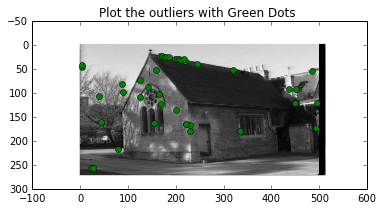

In [5]:
#Plot Outliers on image 1 

fig = plt.figure()

plt.figure(3)
plt.title("Plot the outliers with Green Dots ")
plt.imshow(img1,cmap="gray")
for i in range(len(pts1_outliers)):
    plt.plot(pts1_outliers[i][0],pts1_outliers[i][1],'go') 

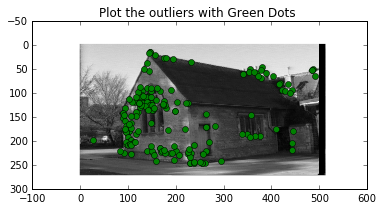

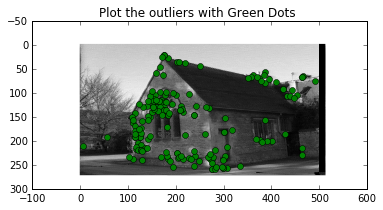

In [6]:
#Select 7 points that match. 
fig = plt.figure()

plt.figure(4)
plt.title("Plot the outliers with Green Dots ")
plt.imshow(img1,cmap="gray")
for i in range(len(pts1_inliers)):
    plt.plot(pts1_inliers[i][0],pts1_inliers[i][1],'go')
    
fig = plt.figure()

plt.figure(5)
plt.title("Plot the outliers with Green Dots ")
plt.imshow(img2,cmap="gray")
for i in range(len(pts2_inliers)):
    plt.plot(pts2_inliers[i][0],pts2_inliers[i][1],'go')
    

In [34]:
pts_matched1 = []
pts_matched2 = []
pts_matched1.append([pts1_inliers[0][0],pts1_inliers[0][1]])
pts_matched1.append([pts1_inliers[30][0],pts1_inliers[30][1]])
pts_matched1.append([pts1_inliers[50][0],pts1_inliers[50][1]])
pts_matched1.append([pts1_inliers[80][0],pts1_inliers[80][1]])
pts_matched1.append([pts1_inliers[100][0],pts1_inliers[100][1]])
pts_matched1.append([pts1_inliers[120][0],pts1_inliers[120][1]])
pts_matched1.append([pts1_inliers[140][0],pts1_inliers[140][1]])

pts_matched2.append([pts2_inliers[0][0],pts2_inliers[0][1]])
pts_matched2.append([pts2_inliers[30][0],pts2_inliers[30][1]])
pts_matched2.append([pts2_inliers[50][0],pts2_inliers[50][1]])
pts_matched2.append([pts2_inliers[80][0],pts2_inliers[80][1]])
pts_matched2.append([pts2_inliers[100][0],pts2_inliers[100][1]])
pts_matched2.append([pts2_inliers[120][0],pts2_inliers[120][1]])
pts_matched2.append([pts2_inliers[140][0],pts2_inliers[140][1]])

In [35]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        cv2.line(img1, (x0,y0), (x1,y1), color,1)
        cv2.circle(img1,tuple(pt1),5,color,-1)
        cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

(<matplotlib.axes._subplots.AxesSubplot at 0x10dd608d0>,
 <matplotlib.image.AxesImage at 0x10e424710>)

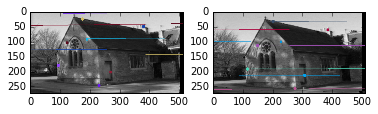

In [36]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
#print pts_matched2
lines1 = cv2.computeCorrespondEpilines(np.array(pts_matched2).reshape(-1,1,2), 2,F_norm)
lines1 = lines1.reshape(-1,3)

img5,img6 = drawlines(img1,img2,lines1,pts_matched1,pts_matched2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(np.array(pts_matched1).reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts_matched2,pts_matched1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)


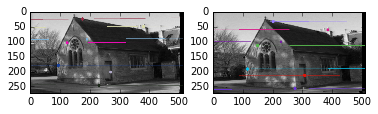

In [42]:
lines1 = cv2.computeCorrespondEpilines(np.array(pts_matched2).reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts_matched1,pts_matched2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(np.array(pts_matched1).reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts_matched2,pts_matched1)

plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

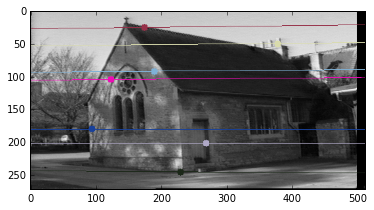

In [45]:
plt.imshow(img5)

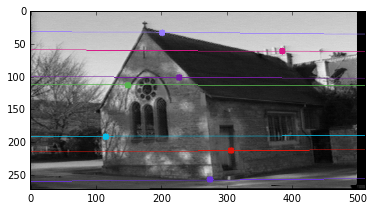

In [46]:
plt.imshow(img3)